In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/data.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
!pip install tensorflow opencv-python numpy scikit-learn matplotlib


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
# Suppress TensorFlow warnings & progress bars
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hide TensorFlow logs
tf.get_logger().setLevel('ERROR')  # Hide Keras progress bar

In [5]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [6]:
# Create a Classifier class

class Classifier:
    def __init__(self):  # Added self
        self.model = None  # Fixed initialization

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)


In [7]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])

    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [9]:
# Instantiate and Load Weights
meso = Meso4()
weight_path = '/content/data/Meso4_DF.h5'

if os.path.exists(weight_path):
    meso.load(weight_path)
else:
    print(f"Warning: Weights file '{weight_path}' not found.")

In [10]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')
# Re-checking class assignment after removing it
generator.class_indices

Found 7104 images belonging to 3 classes.


{'.ipynb_checkpoints': 0, 'DeepFake': 1, 'Real': 2}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted likelihood: 0.9105
Actual label: 2

Correct prediction: False


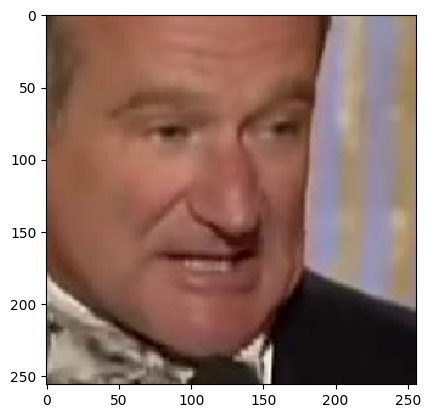

In [11]:
# Fetch one batch of images and labels
X_batch, y_batch = next(generator)  # Use next(generator) instead of generator.next()

# Ensure we are working with a single image
X = X_batch[0:1]  # Extract the first image in the batch
y = y_batch[0]    # Extract the first label

# Evaluating prediction
predicted_likelihood = meso.predict(X)[0][0]
actual_label = int(y)
correct_prediction = round(predicted_likelihood) == actual_label

print(f"Predicted likelihood: {predicted_likelihood:.4f}")
print(f"Actual label: {actual_label}")
print(f"\nCorrect prediction: {correct_prediction}")

# Showing image
plt.imshow(np.squeeze(X));


In [12]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
# Generate predictions on the validation set in batches
batch_size = generator.batch_size  # Get the batch size of the generator

# Iterate over the entire dataset in batch mode
for i in range(len(generator)):
    X_batch, y_batch = next(generator)  # Load a batch of images and labels

    # Generate predictions for the entire batch
    preds = meso.predict(X_batch)[:, 0]  # Get predictions for the batch

    # Round predictions (0 or 1)
    rounded_preds = np.round(preds)

    # Categorize predictions using vectorized operations
    correct_real_mask = (rounded_preds == y_batch) & (y_batch == 1)
    correct_deepfake_mask = (rounded_preds == y_batch) & (y_batch == 0)
    misclassified_real_mask = (rounded_preds != y_batch) & (y_batch == 1)
    misclassified_deepfake_mask = (rounded_preds != y_batch) & (y_batch == 0)

    # Append correct classifications
    correct_real.extend(X_batch[correct_real_mask])
    correct_real_pred.extend(preds[correct_real_mask])
    correct_deepfake.extend(X_batch[correct_deepfake_mask])
    correct_deepfake_pred.extend(preds[correct_deepfake_mask])

    # Append misclassified images
    misclassified_real.extend(X_batch[misclassified_real_mask])
    misclassified_real_pred.extend(preds[misclassified_real_mask])
    misclassified_deepfake.extend(X_batch[misclassified_deepfake_mask])
    misclassified_deepfake_pred.extend(preds[misclassified_deepfake_mask])

    # Print progress every 10 batches instead of every image
    if i % 10 == 0:
        print(f"{i * batch_size} predictions completed.")

print(f"All {len(generator.labels)} predictions completed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0 predictions completed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10 predictions completed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
20 predictions completed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

In [16]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

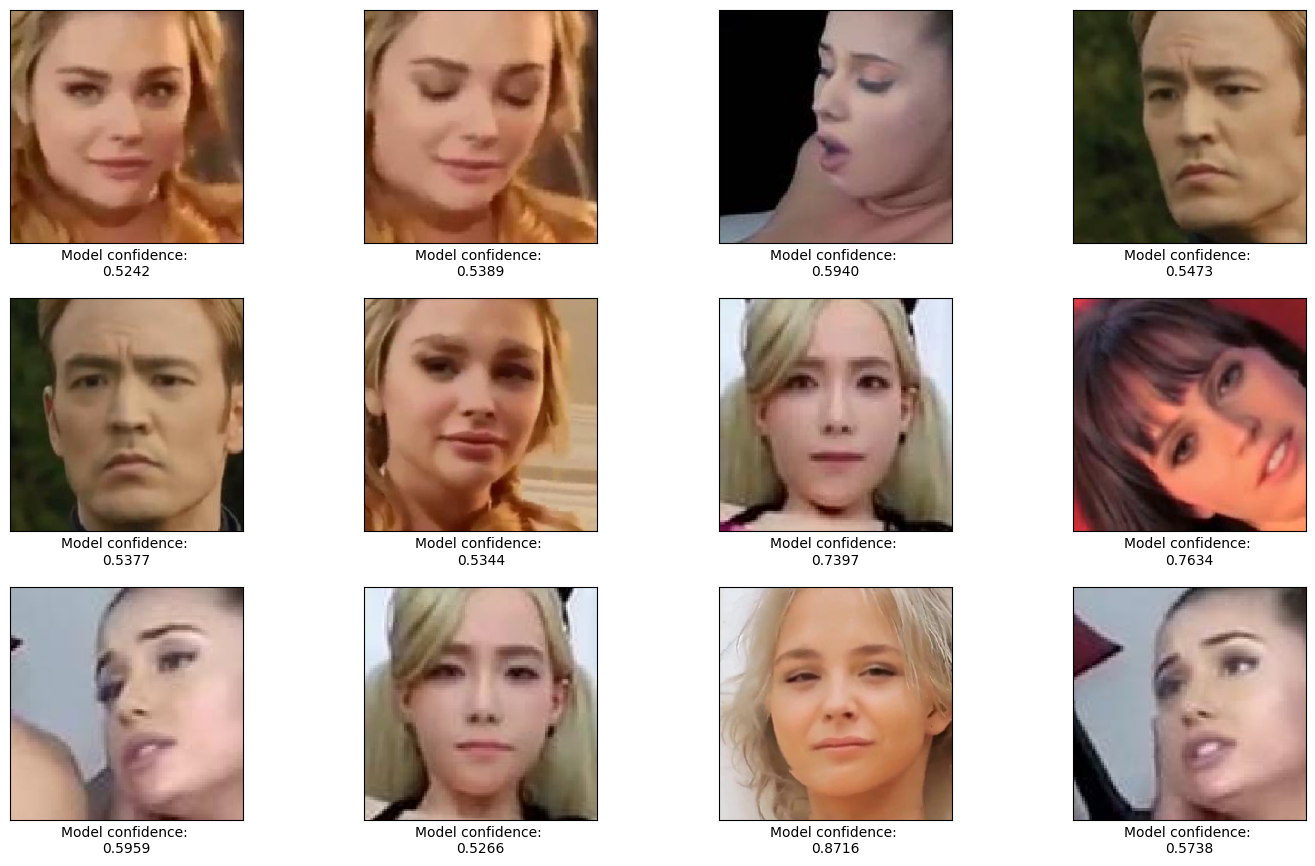

In [17]:
plotter(correct_real, correct_real_pred)

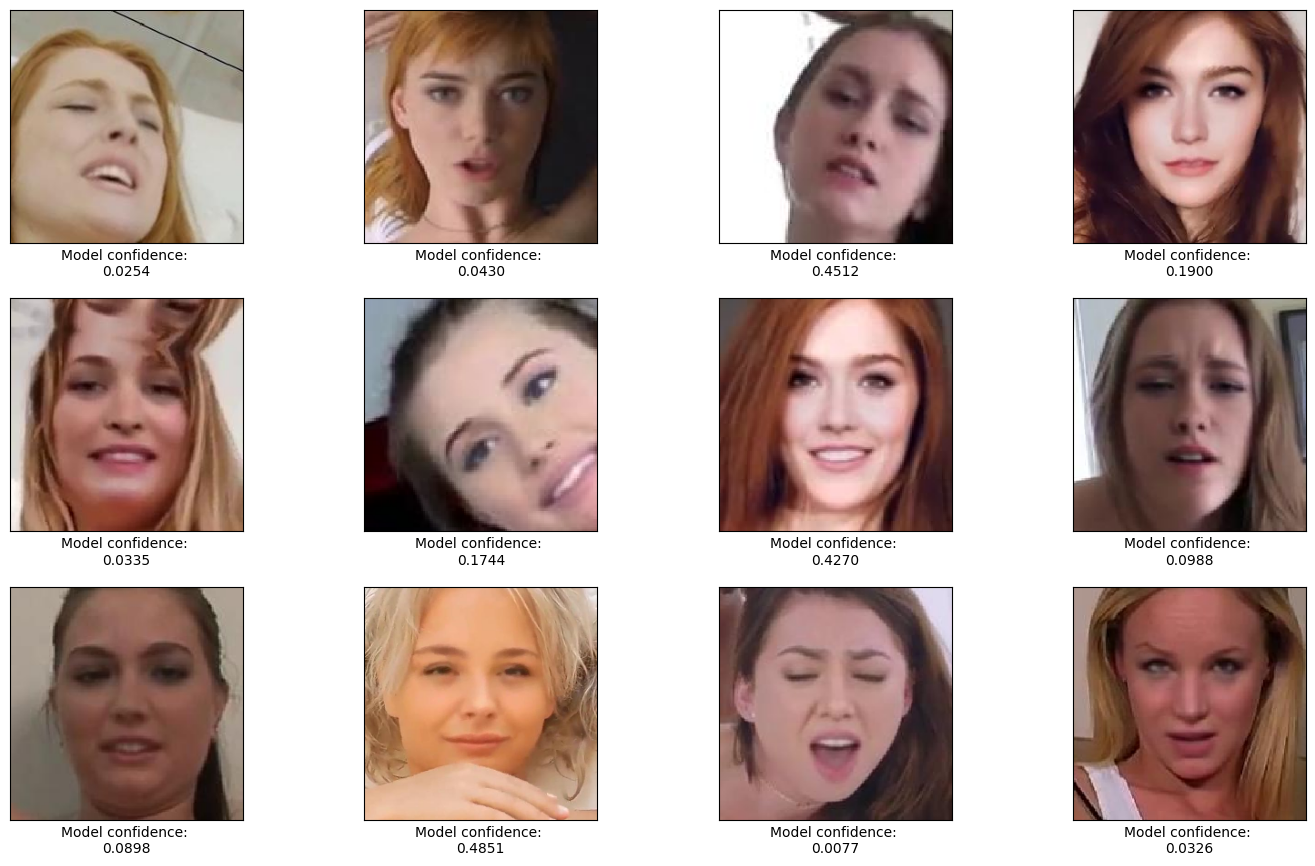

In [18]:
plotter(misclassified_real, misclassified_real_pred)